In [15]:
#add config and make a demo run
from typing import (
    Annotated,
    Sequence,
    TypedDict,
    Union
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_community.tools import DuckDuckGoSearchResults
from langgraph.prebuilt import ToolNode
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_ollama import ChatOllama
from langchain_core.messages import ToolMessage,SystemMessage
from langchain_core.runnables import RunnableConfig
import json


class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]
    generated_exps: dict
    exp_title:str
    reward:Union[int,float]
    comment:str
    Satisfied:bool
    final_formatted:dict
    timestamp:list
    startTime: int
    toolcall_nos:int
    toolcall_counts :list
    generator_tokens: list


wrapper = DuckDuckGoSearchAPIWrapper(max_results=3)
search = DuckDuckGoSearchResults(api_wrapper=wrapper, output_format='list')

tools = [search]

model = ChatOllama(model="qwen2.5:32b",base_url="192.168.23.138:11439")
model = model.bind_tools(tools)

In [16]:
system_message = '''You are a Lab Assistant designed to assist with scientific experiments. Your task is to provide:

Experiment Materials: A list of required materials and equipment.
Experiment Steps: A detailed step-by-step guide for conducting the experiment.
Safety Procedures: Essential precautions to ensure a safe experiment.
Before generating the final response, you will:

Search the query using DuckDuckGo to gather up-to-date and relevant information.
Analyze the results to determine if the information is complete.
Enhance the response by integrating the best available knowledge before providing the final answer.which is not a summary but well explained'''

In [17]:
# class crawlerSchema(BaseModel):
#     title: str = Field(..., description="The title of the article")
#     article: str = Field(..., description="rephrase the article so that it covers every part of the topic in a concise manner in about 500 words")
#     # main_topics: str = Field(..., description="Main topics or themes discussed in the article")
#     materials: str = Field( description="extract all the materials used in the experiment")
#     steps: str = Field( description="exctract Step by step guide for conducting the experiment")
#     safety_procedures: str = Field( description="Safety precautions for the experiment")
toolcall_nos = 0

tools_by_name = {tool.name: tool for tool in tools}
def tool_node(state: AgentState,):
    outputs = []
    global toolcall_nos
    
    for tool_call in state["messages"][-1].tool_calls:
        print("calling tools",state["toolcall_nos"])
        toolcall_nos+=1
        if tool_call["name"] == 'duckduckgo_results_json':
            tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            toSearch = [search['link'] for search in tool_result]
            # print(toSearch)
            crawler_result = None
            pages_result = []
            outputs.append(str(tool_result))
            # return {"messages":str(tool_result)}
            # for url in toSearch:
            #     # print(crawlerSchema.model_json_schema()['properties'])
                
            #     crawler_result = test_llm_with_ollama(tester=Crawl4AiTester(), url=url, schema=crawlerSchema.model_json_schema()['properties'])
            #     # if crawler_result.get('success', False):  # Assuming the result has a 'success' flag
            #         # print(crawler_result)
            #     # print(crawler_result)
            #     pages_result.append(crawler_result)

            # crawler_result = json.dumps({"search_results": pages_result})
            
            # outputs.append(
            #     ToolMessage(
            #         content=crawler_result,
            #         name=tool_call["name"],
            #         tool_call_id=tool_call["id"],
            #     )
            # )
    tcalls = toolcall_nos
    return {"messages": str(outputs),'toolcall_nos':tcalls}
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
    system_prompt = SystemMessage(
        system_message
    )
    response = model.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

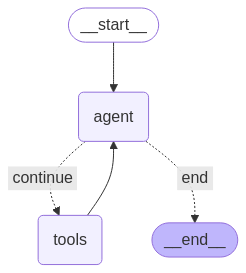

In [18]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
# query = f"what should be the required materials and experiment procedure of the following lab Experiment (To measure the input and output impedances of an operational amplifier (Op-Amp) in a given configuration.)?"
# def print_stream(stream):
#     for s in stream:
#         message = s["messages"][-1]
#         if isinstance(message, tuple):
#             print(message)
#         else:
#             message.pretty_print()


# inputs = {"messages": [("user", query)]}
# print_stream(graph.stream(inputs, stream_mode="values"))

In [20]:
from pydantic import BaseModel,Field
from typing import TypedDict,Annotated
from langchain_ollama import ChatOllama
from langgraph.graph import START, MessagesState, StateGraph,END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage
from typing import Union, Dict
import json

# formatter_llm = ChatOllama(model="jacob-ebey/phi4-tools:latest",base_url="192.168.23.138:11439")
formatter_llm = model
class score(BaseModel):
    score1: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 1")
    score2: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 2")
    score3: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 3")
    score4: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 4")
    score5: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 5")

class JsonnedOutput(BaseModel):
    Accuracy: score = Field(...,description="ratings of the Accuracy in a probabilstic distribution manner")
    Completeness: score = Field(...,description="ratings of the Completeness in a probabilstic distribution manner")
    Clarity: score = Field(...,description="ratings of the Clarity in a probabilstic distribution manner")
    Safety:score = Field(...,description="ratings of the Safety in a probabilstic distribution manner")
    Comment:str = Field(...,description="give a feedback on how to improve the scores")
    Satisfied:bool = Field(...,description="are you satisfied with the experiment return True or False")

def generate_evaluation_prompt(ground_truth: Dict, test_procedure: str) -> str:
    return f"""You are an expert evaluator assessing the accuracy, completeness, clarity, and safety of an electronics experiment procedure. Your primary task is to compare the Test Procedure against the Ground Truth, which serves as the reference standard.

        Ground Truth Procedure
        {json.dumps(ground_truth, indent=2)}

        Test Procedure
        {json.dumps(test_procedure, indent=2)}

        Evaluation Criteria & Scoring Guidelines
        Evaluate the Test Procedure using the following dimensions, ensuring your assessment is tailored to the unique needs of electronics experiments.

        Accuracy (Correctness and Precision)
        Score 5: Near-perfect match with ground truth, including correct component values, circuit connections, and instrument settings (>95% accuracy).
        Score 4: Minor deviations that do not affect experimental outcomes (80-95%).
        Score 3: Some notable errors in component specifications, wiring, or settings that could impact results (60-80%).
        Score 2: Significant inaccuracies that compromise core experiment functionality (40-60%).
        Score 1: Major errors making the experiment unsafe or non-functional (<40%).

        Completeness (Coverage of Required Steps and Details)
        Score 5: All steps, components, and conditions are present and well-defined (>95%).
        Score 4: Minor omissions that don't impact experimental outcomes (80-95%).
        Score 3: Missing some important details, such as critical measurements, equipment setup, or observation steps (60-80%).
        Score 2: Major omissions affecting the experiment's integrity (40-60%).
        Score 1: Severely incomplete, omitting core steps, critical components, or observations (<40%).

        Clarity (Ease of Understanding and Reproducibility)
        Score 5: Clearer than the ground truth or equally clear, with detailed instructions, and well-defined steps.
        Score 4: Mostly clear but may lack minor clarifications or formatting improvements.
        Score 3: Instructions are somewhat ambiguous, potentially requiring interpretation or additional guidance.
        Score 2: Unclear in several steps, risking procedural errors.
        Score 1: Highly confusing, disorganized, or poorly written.

        Safety (Adherence to Safety Protocols and Precautions)
        Score 5: Matches or exceeds ground truth safety measures, including proper ESD precautions, correct handling of power sources, and clear warnings for hazardous steps.
        Score 4: Contains most key safety measures but may lack minor details.
        Score 3: Missing some important safety points that pose moderate risk.
        Score 2: Inadequate safety guidance, posing potential hazards.
        Score 1: Critical safety issues or complete lack of precautionary steps.

        Important Electronics-Specific Considerations
        - Emphasize component values, polarity details, and circuit connections during evaluation.
        - Ensure steps involving voltage ratings, current limits, and instrument calibration are addressed.
        - Check for essential safety measures such as discharging capacitors, short-circuit prevention, and power isolation steps.
        - Highlight the presence of clear circuit connection, pin configurations, and proper labeling as part of clarity evaluation.
        and provide a comment detailing on which part is missing from the test procdure so if it was there then the score would have been higher.
        also provide wether you are satisfied with the test procedure and to be satisfied return True or False.
        Response Format (Strict JSON)
        Please provide your evaluation in the following format:
        {{
            "Accuracy": {{
                "1": probability,
                "2": probability,
                "3": probability,
                "4": probability,
                "5": probability
            }},
            "Completeness": {{
                "1": probability,
                "2": probability,
                "3": probability,
                "4": probability,
                "5": probability
            }},
            "Clarity": {{
                "1": probability,
                "2": probability,
                "3": probability,
                "4": probability,
                "5": probability
            }},
            "Safety": {{
                "1": probability,
                "2": probability,
                "3": probability,
                "4": probability,
                "5": probability
            }}
            "Comment": string <<how to improve the test procedure>>,
            "Satisfied": bool
        }}

        Evaluation Guidance
        - Assign higher probabilities to scores 4 and 5 when the Test Procedure closely matches the Ground Truth.
        - Shift probabilities downward if errors, omissions, or clarity issues are significant.
        - Consider safety lapses with extra caution — even minor gaps may justify lower scores for safety.
        """

formatter = model.with_structured_output(JsonnedOutput,method='json_mode')
class State(TypedDict):
    input: str
    output: Union[JsonnedOutput,None]

workflow = StateGraph(state_schema=State)
def generate_graph_evaluation(state:State,config:RunnableConfig):
    # print(state["input"])
    response = model.invoke(state["input"],config)
    # print("----------------------------->",response)
    formatted_response = formatter.invoke(f"based on the {response.content} only output probabilities of each criteria and Leave everything. OUTPUT in the following json manner {{'Accuracy': {{ 'score1': p1, 'score2': p2, 'score3': p3, 'score4': p4, 'score5': p5 }}, 'Completeness': {{ 'score1': p1, 'score2': p2, 'score3': p3, 'score4': p4, 'score5': p5 }}, 'Clarity': {{ 'score1': p1, 'score2': p2, 'score3': p3, 'score4': p4, 'score5': p5 }},'Safety': {{ 'score1': p1, 'score2': p2, 'score3': p3, 'score4': p4, 'score5': p5 }},'Comment':<<comment to improve the score>>,'Satisfied:<<are you satisfied with the response or not return True or False }} but ensure that the json format is correct")
    # print(formatted_response)
    return {"output":{"Accuracy": formatted_response.Accuracy, "Completeness": formatted_response.Completeness,"Clarity":formatted_response.Clarity,"Safety": formatted_response.Safety,"Comment":formatted_response.Comment,"Satisfied":formatted_response.Satisfied}}

workflow.add_node("evaluator",generate_graph_evaluation)
workflow.add_edge(START,"evaluator")
workflow.add_edge("evaluator",END)
eval_graph = workflow.compile()
import os

def list_files_in_directory(directory):
    try:
        files = os.listdir(directory)
        return files
    except FileNotFoundError:
        print(f"The directory {directory} does not exist.")
    except PermissionError:
        print(f"Permission denied to access the directory {directory}.")
from typing import Dict, Optional
def evaluate_experiment(ground_truth: Dict, test_procedure: str):
    prompt = generate_evaluation_prompt(ground_truth, test_procedure)


    event = eval_graph.invoke({"input": prompt, "output": None })
        # print(event)
    # Debug: Print the raw response to see what the model is returning
    try:
        return event['output']
    except KeyError:
        return event

    

In [21]:
import logging
import json
import re
import logging
from typing import Dict, Optional
from typing import TypedDict,Literal
import tqdm
# logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s: %(message)s")
# logger = logging.getLogger(__name__)

def load_json(filepath: str) -> Dict:
    try:
        with open(filepath, "r", encoding="utf-8") as file:
            return json.load(file)
    except FileNotFoundError:
        # logger.error(f"File not found: {filepath}")
        print("file not found")
        raise
    except json.JSONDecodeError:
        # logger.error(f"Invalid JSON in file: {filepath}")
        print("file not found")
        raise
def extract_json_from_response(response_text: str) -> Optional[Dict]:
    try:
        json_match = re.search(r"\{.*\}", response_text, re.DOTALL)  # Extracts only JSON part
        if json_match:
            return json.loads(json_match.group())
        else:
            # logger.error("No valid JSON found in response.")
            print("file not found")
            return None
    except json.JSONDecodeError as e:
        # logger.error(f"JSON parsing error: {e}")
        print("file not found")
        return None



from typing import Union, Literal
import json

def load_json(file_path: str):
    with open(file_path, "r", encoding="utf-8") as file:
        return json.load(file)

def run_evaluation(
    ground_truth_path: str, 
    results_path: Union[str, dict],  
    plots: dict, 
    mode: Literal["feedback", "judge"] = "judge"
):
    # Load ground truth data
    ground_truth_data = load_json(ground_truth_path)
    ground_truth_dict = {exp["title"]: exp for exp in ground_truth_data["experiments"]}

    # Load LLM generated results based on mode
    if mode == "judge":
        llm_generated_results = load_json(results_path)["experiments"]
    elif mode == "feedback":
        llm_generated_results = results_path

    # Initialize evaluation results
    for chosen_exps in llm_generated_results:
        for title, test_procedure in chosen_exps.items():
            ground_truth = ground_truth_dict.get(title)

            if ground_truth:
                # Evaluate the experiment
                result = evaluate_experiment(ground_truth, test_procedure)
                # print(result)
                comment = result.pop('Comment')
                satisfied = result.pop('Satisfied')
                # print(result)
                # Aggregate scores into plots
                for key, values in result.items():
                    # print(values)
                    score = (
                        1 * float(values.score1) +
                        2 * float(values.score2) +
                        3 * float(values.score3) +
                        4 * float(values.score4) +
                        5 * float(values.score5)
                    )
                    plots[key].append(score)
    # print(comment)
    # Handle output based on mode
    if mode == "judge":
        return plots
    else:
        # return 4.0
        total_reward = sum(plots[key][-1] for key in plots.keys())
        average_reward = total_reward / len(plots.keys())
        return average_reward,comment,satisfied


In [22]:
class formatted_output(BaseModel):
    title:str = Field(...,description="title the title of the experiment")
    objective:str = Field(...,description="copy the objective of the experiment")
    materials:list = Field(...,description="copy the materials of the experiment")
    procedure:dict = Field(...,description="copy th procedure of the experiment")

final_formatter = model.with_structured_output(formatted_output,method='json_mode')

In [23]:
import time 
iteration = 0
def run_generator(state:AgentState):
    global iteration
    iteration+=1
    t = time.time()
    # state[] = 0
    print(state["messages"][-1])
    tok_gen = []
    tok_gen.append(state['generator_tokens'])
    response = graph.invoke({"messages":  state["messages"][-1],"toolcall_nos":state['toolcall_nos']})
    tok_gen.append(response["messages"][-1].response_metadata['eval_count'])
    print(response["messages"][-1].response_metadata['eval_count'])
    with open("running_exp.md",'w',encoding='utf-8') as F:
        F.write(response["messages"][-1].content)
    return{"generated_exps":{state["exp_title"]: response["messages"][-1].content},'startTime':t,"toolcall_nos":response['toolcall_nos'],'generator_tokens': tok_gen }

def run_evalutator(state:AgentState):
    global toolcall_nos
    gt = "non_code_files/experiments_2.json"
    plots = {'Accuracy':[],'Clarity':[],'Completeness':[],'Safety':[]}
    response,comment,satisfied = run_evaluation(ground_truth_path=gt,results_path=[state["generated_exps"]],mode="feedback",plots=plots)
    print(response,satisfied,comment)
    final_time = time.time() - state["startTime"]
    print(state['timestamp'])
    timess= state['timestamp']+ [final_time] 
    tcalls = state['toolcall_counts'] + [state['toolcall_nos']]
    toolcall_nos = 0
    return {"reward":response,"messages":["for the given experiment "+state['exp_title'] +"improve the given experiment :"+str(state['generated_exps'][state['exp_title']])+" by incorporating the following comment"+comment],"Satisfied":satisfied,'timestamp':timess,'toolcall_counts':tcalls}

def finally_formatter(state:AgentState):
    
    while True:
        try:
            resp = final_formatter.invoke(f"format the following experiment into the following category{state["generated_exps"]} of title in string, objective also in string, materials list of materials used in list,procedure copy the procedure from the given experiment and write it in a dictionary format")
            break
        except Exception as e:
            print("->", e)
    

    return {'final_formatted': {state['exp_title']:dict(resp)},}
finish_on_next = False
def continue_condition(state: AgentState):
    global finish_on_next, iteration
    if iteration>5:
        return "finish"
    elif (not state["Satisfied"]) and not finish_on_next:
        return "continue"
    elif (state["Satisfied"]) and not finish_on_next:
        finish_on_next = True
        return 'continue'
    else: 
        finish_on_next = False
        return 'finish'    


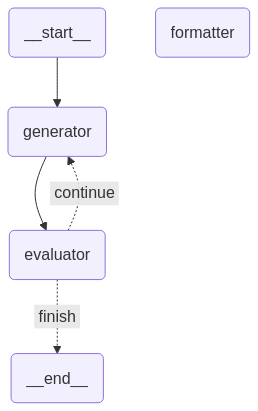

In [24]:
feedback_workflow = StateGraph(AgentState)
feedback_workflow.add_node("generator",run_generator)
feedback_workflow.add_node("evaluator",run_evalutator)
feedback_workflow.add_node("formatter",finally_formatter)
feedback_workflow.set_entry_point("generator")
feedback_workflow.add_conditional_edges("evaluator",continue_condition,{"continue":"generator","finish":END})
feedback_workflow.add_edge("generator","evaluator")
# feedback_workflow.add_edge("formatter",END)
feedback_graph = feedback_workflow.compile()
feedback_graph

In [25]:
# exps_name = "To measure the input and output impedances of an operational amplifier (Op-Amp) in a given configuration."
# query = f"what should be the required materials and experiment procedure of the following lab Experiment ({exps_name})?"
# state= AgentState()
# inputs = {"messages": [("user", query)],"exp_title":exps_name}
# # for event in feedback_graph.stream(inputs):
# #     # p
# #     print(event)
# event = feedback_graph.invoke(inputs)

In [26]:
# print(event["generated_exps"])

In [27]:
experiment_name = [
    "Verification of Ohm's Law: Relationship Between Voltage (V), Current (I), and Resistance (R)",
    "Application and Verification of Kirchhoff's Voltage Law (KVL) and Kirchhoff's Current Law (KCL) in Electrical Circuits",
    "Investigation of Resistors in Series and Parallel Configurations with Equivalent Resistance Calculations",
    "Analysis of Forward and Reverse Bias Characteristics of a PN Junction Diode and Voltage Regulation Using a Zener Diode",
    "To analyze voltage regulation using a Zener diode.",
    "To construct and analyze the performance of half-wave and full-wave rectifiers, both with and without filters.",
    "To analyze and implement wave-shaping circuits using diodes for clipping and clamping applications.",
    "To analyze the input and output characteristics of Bipolar Junction Transistors (BJTs) and Field-Effect Transistors (FETs).",
    "Design and Frequency Response Analysis of a Common Emitter Amplifier",
    "To implement and analyze operational amplifier (Op-Amp) circuits: inverting, non-inverting, summing, and differentiator configurations.",
    "To verify the operation of basic logic gates: AND, OR, NOT, NAND, NOR, XOR, and XNOR",
    "Investigation of Charging and Discharging Behavior of a Capacitor in an RC Circuit and Understanding the Time Constant",
    "To investigate the resonance behavior of an LC circuit and measure the resonant frequency.",
    "Calibration of an Oscilloscope for Accurate Voltage and Time Measurements",
    "Determining the Turns Ratio of a Transformer and Verifying the Relationship Between Primary and Secondary Voltages",
    "Construction and Analysis of Bridge Rectifier Circuit with Performance Comparison to Half-Wave Rectifier",
    "To study the frequency response of a low-pass filter and determine its cutoff frequency.",
    "To measure the input and output impedances of an operational amplifier (Op-Amp) in a given configuration.",
    "Generation and Analysis of Lissajous Figures Using an Oscilloscope",
    "Study of the Magnetic Field Produced by a Solenoid and Verification of the Relationship Between Current and Magnetic Field Strength",
    
]
# experiment_name = [experiment_name[8]]


In [28]:
experiment_dict = {"experiments":[]}
timestamp_dict = {}
toolcall_dict = {}
gentok_dict = {}
for exp in experiment_name:
    iteration = 0
    query = f"what should be the required materials and experiment procedure of the following lab Experiment ({exp})?"
    state= AgentState()
    inputs = {"messages": [("user", query)],"exp_title":exp,'timestamp':[],"toolcall_counts":[],"toolcall_nos":1,'generator_tokens':[]}
    # for event in feedback_graph.stream(inputs):
    #     # p
    #     print(event)
    # event = feedback_graph.invoke(inputs)
    while True:
        try:
            event = feedback_graph.invoke(inputs)
            break
        except Exception as e:
            print("---------------------> ", e)
            continue
    
    print(exp)
    timestamp_dict.update({exp:event['timestamp']})
    toolcall_dict.update({exp:event['toolcall_counts']})
    gentok_dict.update({exp:event['generator_tokens']})
    experiment_dict["experiments"].append(event["generated_exps"])
    # break
timestamp_dict = {'timestamps':timestamp_dict}
toolcall_dict = {'toocalls':toolcall_dict}
gentok_dict = {'generation_counts': gentok_dict}

content="what should be the required materials and experiment procedure of the following lab Experiment (Verification of Ohm's Law: Relationship Between Voltage (V), Current (I), and Resistance (R))?" additional_kwargs={} response_metadata={} id='07806c35-82b2-4299-814e-36a6d3bfe552'
calling tools 1
804
4.0125 True The test procedure is detailed and covers most necessary steps, but it lacks specific details such as exact voltage ratings for the power supply, precise current limits to avoid overheating, and more explicit instructions on instrument calibration. Adding these specifics would improve accuracy and completeness.
[]
content="for the given experiment Verification of Ohm's Law: Relationship Between Voltage (V), Current (I), and Resistance (R)improve the given experiment :Based on the information gathered, here is a detailed guide for conducting an experiment to verify Ohm's Law:\n\n### Experiment Materials:\n1. **Conductor**: A length of Nichrome wire or any other alloy material

In [29]:
toolcall_dict

{'toocalls': {"Verification of Ohm's Law: Relationship Between Voltage (V), Current (I), and Resistance (R)": [1,
   1],
  "Application and Verification of Kirchhoff's Voltage Law (KVL) and Kirchhoff's Current Law (KCL) in Electrical Circuits": [1,
   1,
   1],
  'Investigation of Resistors in Series and Parallel Configurations with Equivalent Resistance Calculations': [1,
   1,
   1],
  'Analysis of Forward and Reverse Bias Characteristics of a PN Junction Diode and Voltage Regulation Using a Zener Diode': [1,
   1],
  'To analyze voltage regulation using a Zener diode.': [1, 1],
  'To construct and analyze the performance of half-wave and full-wave rectifiers, both with and without filters.': [1,
   1,
   1],
  'To analyze and implement wave-shaping circuits using diodes for clipping and clamping applications.': [1,
   1,
   2],
  'To analyze the input and output characteristics of Bipolar Junction Transistors (BJTs) and Field-Effect Transistors (FETs).': [1,
   1],
  'Design and Fre

In [30]:
experiment_dict

{'experiments': [{"Verification of Ohm's Law: Relationship Between Voltage (V), Current (I), and Resistance (R)": "Based on the gathered information and additional details, here is an improved guide for conducting an experiment to verify Ohm's Law:\n\n### Experiment Materials:\n1. **Conductor**: A length of Nichrome wire or other alloy material such as constantan (Eureka) or manganin.\n2. **Power Supply**: Adjustable battery pack or power supply unit with a range up to 30V DC.\n3. **Rheostat/Variac**: Variable resistor to control the current in the circuit, capable of handling at least 1 kΩ - 100 kΩ resistance values.\n4. **Ammeter**: To measure electric current flowing through the conductor (0-600 mA range).\n5. **Voltmeter**: To measure voltage across the conductor (0-3V range; extendable up to 30V if necessary).\n6. **Wires and Connectors**: Copper wires with crocodile clips for connecting components.\n7. **Multimeter** (optional): For measuring resistance directly if required.\n8. 

In [31]:
import json
experiment_dict.update(timestamp_dict)
experiment_dict.update(gentok_dict)
experiment_dict.update(toolcall_dict)
with open("phi4_exps_w_feedback/qwen_feedback_output_3.json","w") as F:
    json.dump(experiment_dict,F,indent=4)

In [32]:
a =  {'a':23}
b = {'a':54}
a.update(b)
a

{'a': 54}

In [33]:
# with open("exps.json","w") as F:
#     F.write(json.dumps(experiment_dict))

In [34]:
from IPython.display import Markdown, display

display(Markdown(experiment_dict['experiments'][0][exp]))

KeyError: 'Study of the Magnetic Field Produced by a Solenoid and Verification of the Relationship Between Current and Magnetic Field Strength'

In [ ]:
import json

# Load the JSON file
file_path = "phi4_exps_w_feedback/mistral_feedback_output_1.json"
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Extract all components and count them
total_components = 0
components_with_values = 0

# Keywords for identifying components with values
value_indicators = ["Ω", "ohm", "kΩ", "MΩ", "µF", "uF", "F", "H", "mH", "μH", "V", "A", "mA"]

# Iterate through experiments to find component mentions
for experiment in data.get("experiments", []):
    for key, content in experiment.items():
        lines = content.split("\n")
        for line in lines:
            if any(keyword in line.lower() for keyword in ["resistor", "capacitor", "diode", "transistor", "op-amp", "voltmeter", "ammeter", "power supply", "inductor", "multimeter", "oscilloscope", "wire", "breadboard"]):
                total_components += 1
                if any(value in line for value in value_indicators):
                    components_with_values += 1

total_components, components_with_values


FileNotFoundError: [Errno 2] No such file or directory: 'phi4_exps_w_feedback/mistral_feedback_output_1.json'